<a href="https://colab.research.google.com/github/Oz174/AirportAirplaneDetect/blob/main/Airplane_Detection_T1_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedtarekabdellatif","key":"329f27a37418141c8839d5e57ddaa7a4"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 76 Dec  2 13:02 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pwd

/content


In [ ]:
#!/bin/bash
!kaggle datasets download zidane10aa/airplanes-satellite-imagery

Dataset URL: https://www.kaggle.com/datasets/zidane10aa/airplanes-satellite-imagery
License(s): apache-2.0
 98% 68.0M/69.1M [00:04<00:00, 22.4MB/s]
100% 69.1M/69.1M [00:04<00:00, 15.5MB/s]


In [ ]:
!unzip airplanes-satellite-imagery.zip

Archive:  airplanes-satellite-imagery.zip
  inflating: test/images/014de911-7810-4f7d-8967-3e5402209f4a_0_0_jpg.rf.7b6e48f643ecb69e2a57f0dc685686ce.jpg  
  inflating: test/images/014de911-7810-4f7d-8967-3e5402209f4a_1060_0_jpg.rf.387550d1c7773e2df29177609a015210.jpg  
  inflating: test/images/0263270b-e3ee-41dc-aeef-43ff77e66d5b_1060_0_jpg.rf.52916237bb7f39fe2cdb9d0f2ef9f8da.jpg  
  inflating: test/images/03f84930-e2be-4c19-9afc-0dc26d02538e_0_0_jpg.rf.77249831f4593500ee0a759d539f9c3f.jpg  
  inflating: test/images/03f84930-e2be-4c19-9afc-0dc26d02538e_1060_0_jpg.rf.9e350b58bb04ecfcb58eac59cb89642a.jpg  
  inflating: test/images/03f84930-e2be-4c19-9afc-0dc26d02538e_1060_0_jpg.rf.c8ac4f9068dde47da4ac0211f59e751b.jpg  
  inflating: test/images/03f84930-e2be-4c19-9afc-0dc26d02538e_1060_1060_jpg.rf.bf5cd12a6da945cb78557e6e071f48d4.jpg  
  inflating: test/images/0641acc3-c0b9-4f9d-b0ba-7ad18aa08864_0_0_jpg.rf.4d03f309e64d88cf7335a70126b8653d.jpg  
  inflating: test/images/0641acc3-c0b9-4f9d-

# Airplane Detection Using YOLO
0. Import Relevant Libraries
1. Dataset Exploration
    1. Images per set
    2. Checking sample images for noise
    3. Checking if bounding boxes are correct.
2. YOLO
   1. General Inference
   2. Transfer Learning
   3. Testing

In [ ]:
!pip install -U ipywidgets ultralytics opencv-python -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.0 MB/s eta 0:00:00


In [ ]:
import ultralytics
from ultralytics import YOLO
import cv2
import os
import shutil
import matplotlib.pyplot as plt
import random
import yaml
from PIL import Image

In [ ]:
def extract_labels(label_txt_file):
    """
    Reads a label text file and returns a list of labels in float format.
    Each label is represented as [class_id, x_center, y_center, width, height].

    :param label_txt_file: Path to the .txt file containing labels.
    :return: List of labels where each label is [class_id, x_center, y_center, width, height].
    """
    labels = []
    try:
        with open(label_txt_file, 'r') as file:
            for line in file:
                # Split the line into individual elements and convert to float
                labels.append(list(map(float, line.strip().split())))
    except FileNotFoundError:
        print(f"Label file {label_txt_file} not found.")
    except Exception as e:
        print(f"An error occurred while reading {label_txt_file}: {e}")

    return labels

def draw_bounding_boxes(image, labels, class_names=['plane']):
    """
    Draws bounding boxes on an image.
    :param image: The image to draw on (numpy array).
    :param labels: A list of labels where each label is [class_id, x_center, y_center, width, height].
    :param class_names: (Optional) List of class names.
    """
    h, w, _ = image.shape  # Image dimensions
    for label in labels:
        class_id, x_center, y_center, box_width, box_height = label
        # Denormalize coordinates
        x_center, y_center = int(x_center * w), int(y_center * h)
        box_width, box_height = int(box_width * w), int(box_height * h)
        # Calculate top-left and bottom-right coordinates
        x1, y1 = x_center - box_width // 2, y_center - box_height // 2
        x2, y2 = x_center + box_width // 2, y_center + box_height // 2
        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        # Draw label
        label_text = class_names[int(class_id)] if class_names else f"Class {int(class_id)}"
        cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    return image

def write_yaml_file():
    """
    Creates .yaml file for the airplanes dataset
    """
    config = {
    'train': '/content/train/images',
    'val': '/content/valid/images',
    'nc': 1,
    'names': [0]
    }

    with open('/content/data.yaml', 'w') as f:
        yaml.dump(config, f)

    return

In [ ]:
extract_labels('/content/test/labels/014de911-7810-4f7d-8967-3e5402209f4a_0_0_jpg.rf.7b6e48f643ecb69e2a57f0dc685686ce.txt')

[[0.0, 0.95703125, 0.38828125, 0.0546875, 0.0546875],
 [0.0, 0.8828125, 0.5515625, 0.06875, 0.053125],
 [0.0, 0.90234375, 0.711328125, 0.1171875, 0.11328125],
 [0.0, 0.96953125, 0.9875, 0.0609375, 0.025],
 [0.0, 0.65859375, 0.916796875, 0.1015625, 0.08984375],
 [0.0, 0.7734375, 0.9734375, 0.078125, 0.053125],
 [0.0, 0.166796875, 0.905078125, 0.05234375, 0.03828125],
 [0.0, 0.171484375, 0.80625, 0.06171875, 0.05],
 [0.0, 0.17578125, 0.71796875, 0.0515625, 0.0296875],
 [0.0, 0.25390625, 0.65703125, 0.0703125, 0.0546875],
 [0.0, 0.537890625, 0.51796875, 0.05703125, 0.0484375]]

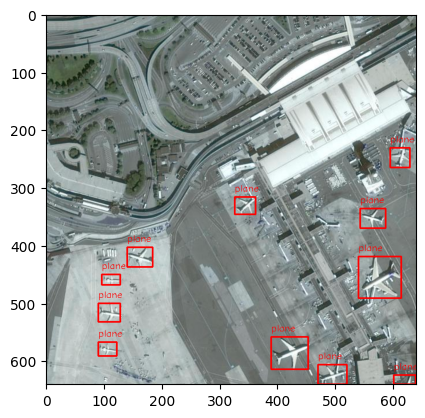

In [ ]:
img = cv2.imread('/content/test/images/014de911-7810-4f7d-8967-3e5402209f4a_0_0_jpg.rf.7b6e48f643ecb69e2a57f0dc685686ce.jpg')
label_txt = '/content/test/labels/014de911-7810-4f7d-8967-3e5402209f4a_0_0_jpg.rf.7b6e48f643ecb69e2a57f0dc685686ce.txt'
labels = extract_labels(label_txt)
image_with_box = draw_bounding_boxes(img,labels)
plt.imshow(image_with_box)

## Dataset Exploration

### Images per set + Image Size

In [ ]:
import os
start_path = '/content/'
for dirname, _, filenames in os.walk(start_path):
    if 'drive' in dirname:
        continue

    if 'images' in dirname and len(filenames) != 0:
        print(f"{dirname.split('/')[-2]} set has {len(filenames)} images")


valid set has 149 images
train set has 700 images
test set has 149 images


In [ ]:
img = cv2.imread('/content/train/images/014de911-7810-4f7d-8967-3e5402209f4a_0_0_jpg.rf.77e233628eec19d0fa0cc4a57a977fce.jpg')
print(img.shape)

(640, 640, 3)


In [ ]:
img = cv2.imread('/content/test/images/03f84930-e2be-4c19-9afc-0dc26d02538e_0_0_jpg.rf.77249831f4593500ee0a759d539f9c3f.jpg')
print(img.shape)

(640, 640, 3)


we can see that both train and test images are of same size 640 as yolo expects

### Checking Images for noise

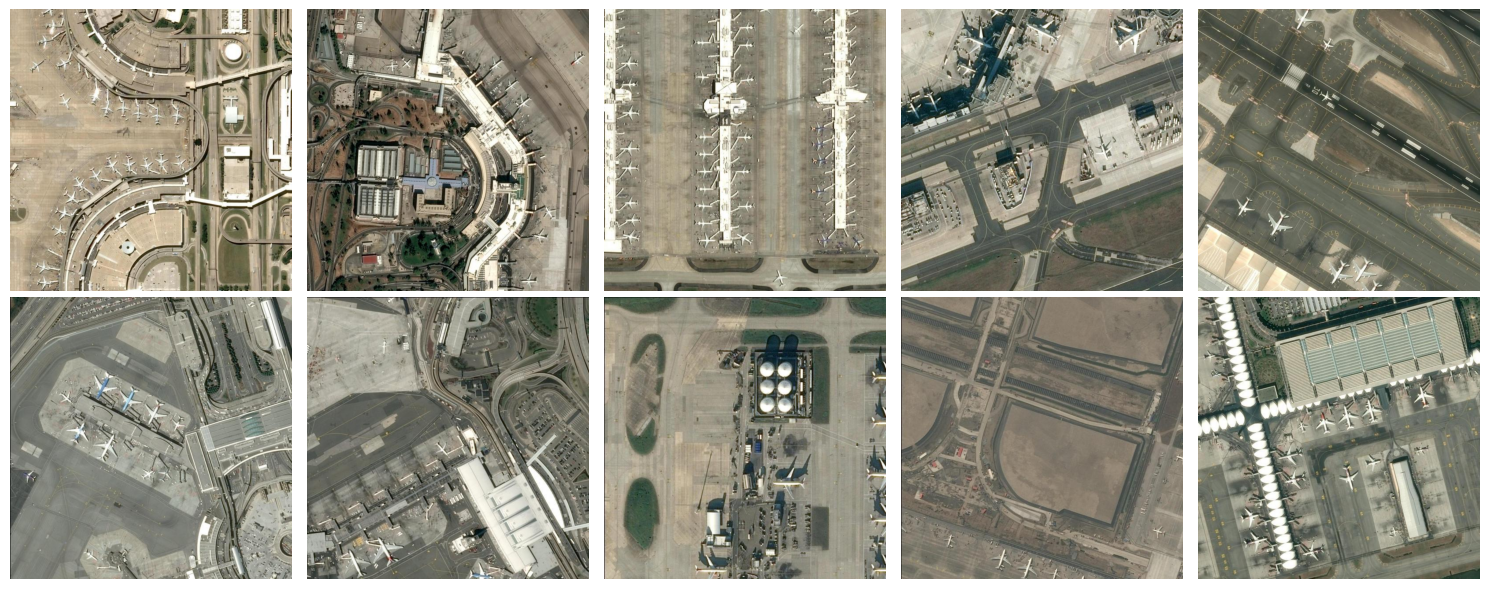

In [ ]:
# Path to the images directory
images_path = "/content/train/images"

# List all image files in the directory
image_files = [file for file in os.listdir(images_path) if file.endswith(('.jpg'))]

image_files = random.sample(image_files, 10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx, ax in enumerate(axes.ravel()):
    # Read and display each image
    image = cv2.imread(os.path.join(images_path, image_files[idx]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    ax.axis('off')  # Hide axis

# Adjust layout
plt.tight_layout()
plt.show()

Images are free of noise , darkened areas and can be used for training.

### Check correct Bounding boxes

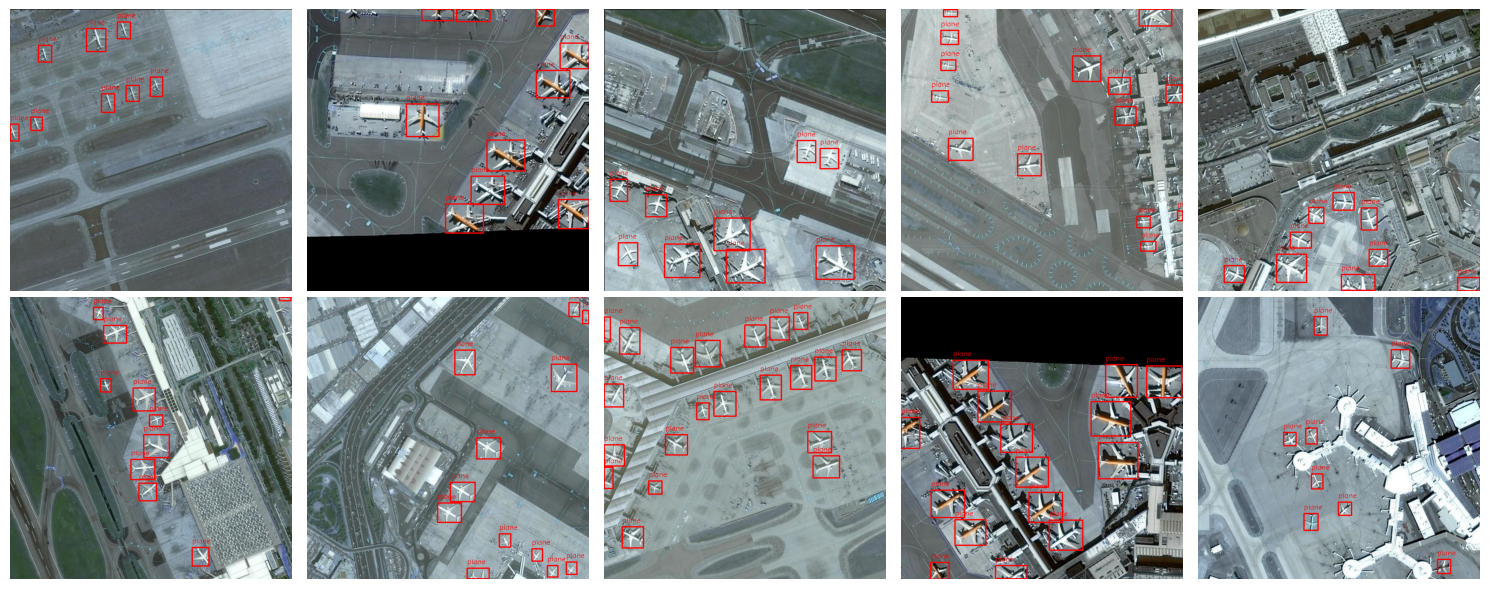

In [ ]:
# Path to the images directory
images_path = "/content/train/images"
labels_path = "/content/train/labels"
# List all image files in the directory
image_files = [file for file in os.listdir(images_path)]

image_files = random.sample(image_files, 10)
label_files = [f.split('.jpg')[0] + '.txt' for f in image_files]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx, ax in enumerate(axes.ravel()):
    # Read and display each image
    image = cv2.imread(os.path.join(images_path, image_files[idx]))
    label = os.path.join(labels_path, label_files[idx])
    label = extract_labels(label)
    images_with_boxes = draw_bounding_boxes(image,label)
    ax.imshow(images_with_boxes)
    ax.axis('off')  # Hide axis

# Adjust layout
plt.tight_layout()
plt.show()

## YOLO

### General Inference

it was for tsting purposes and it turned out that yolov10 exceeded them all (the nano version)

In [ ]:
# we require the nano version for training speed (DON'T RUN THIS)
# models = []
# yolos = ['yolov8n.pt','yolov9t.pt','yolov10n.pt','yolo11n.pt']
# for yolo in yolos:
#     model = YOLO(yolo)
#     results = model('/kaggle/input/catdogimage/maxresdefault.jpg')
#     for result in results:
#         result.show()
#     models.append(model)


In [ ]:
yolo10 = YOLO('yolov10n.pt')

100%|██████████| 5.59M/5.59M [00:00<00:00, 347MB/s]


In [ ]:
write_yaml_file()

### Trasnfer Learning

In [ ]:
yolo10.train(data='/content/data.yaml',pretrained=True,patience=5,epochs=30,batch=16,save=True,device=0,single_cls=True)


Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/content/data.yaml, epochs=30, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

100%|██████████| 755k/755k [00:00<00:00, 68.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 271MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 700 images, 0 backgrounds, 0 corrupt: 100%|██████████| 700/700 [00:00<00:00, 1556.33it/s]

train: New cache created: /content/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/valid/labels... 149 images, 0 backgrounds, 0 corrupt: 100%|██████████| 149/149 [00:00<00:00, 619.09it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.28G      3.402      4.925      2.262        192        640: 100%|██████████| 44/44 [00:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

                   all        149       1957     0.0233      0.533      0.392      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.21G      2.867      2.589      2.042        167        640: 100%|██████████| 44/44 [00:15<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]

                   all        149       1957      0.971       0.24      0.683      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.62G      2.833      2.198      2.067        238        640: 100%|██████████| 44/44 [00:15<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all        149       1957      0.752      0.699      0.785      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.48G      2.855      2.002      2.076        264        640: 100%|██████████| 44/44 [00:15<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all        149       1957      0.833       0.81      0.875      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.36G      2.867      1.878      2.061        136        640: 100%|██████████| 44/44 [00:15<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

                   all        149       1957      0.866      0.814      0.895      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.53G      2.728      1.672      2.019        201        640: 100%|██████████| 44/44 [00:16<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

                   all        149       1957      0.863      0.854      0.905      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.61G      2.633       1.52      2.014        178        640: 100%|██████████| 44/44 [00:17<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        149       1957      0.908      0.849      0.914      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.51G      2.646      1.431      2.004        238        640: 100%|██████████| 44/44 [00:17<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

                   all        149       1957      0.909      0.863      0.916      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.35G      2.631      1.374      2.006        142        640: 100%|██████████| 44/44 [00:17<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

                   all        149       1957      0.909      0.865      0.915      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.32G      2.605      1.378      2.021        168        640: 100%|██████████| 44/44 [00:17<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        149       1957      0.898      0.892      0.923      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.25G      2.601      1.342      1.991        120        640: 100%|██████████| 44/44 [00:17<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.78it/s]

                   all        149       1957      0.923      0.859      0.921      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.44G      2.595      1.316      2.005        208        640: 100%|██████████| 44/44 [00:17<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        149       1957      0.915      0.891      0.925      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.56G      2.576      1.252      1.995        221        640: 100%|██████████| 44/44 [00:17<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

                   all        149       1957      0.923      0.891      0.925      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.38G      2.511      1.217      1.973        248        640: 100%|██████████| 44/44 [00:17<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all        149       1957      0.921      0.895      0.929      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.47G      2.507      1.196      1.973        217        640: 100%|██████████| 44/44 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        149       1957      0.914      0.902      0.928      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.26G      2.466      1.137      1.959        287        640: 100%|██████████| 44/44 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        149       1957      0.939      0.903      0.937      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.44G      2.449      1.143      1.968        254        640: 100%|██████████| 44/44 [00:16<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        149       1957      0.921       0.91      0.931      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.27G      2.437       1.11      1.967        211        640: 100%|██████████| 44/44 [00:16<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        149       1957      0.929      0.917      0.939      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.27G      2.437      1.113      1.966        144        640: 100%|██████████| 44/44 [00:15<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        149       1957       0.93      0.916      0.936      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.43G       2.42      1.091      1.943        232        640: 100%|██████████| 44/44 [00:16<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

                   all        149       1957      0.937      0.913       0.94      0.647


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.21G      2.341      1.009      1.965        101        640: 100%|██████████| 44/44 [00:17<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]

                   all        149       1957       0.94      0.904      0.939      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.13G      2.308     0.9668      1.946        155        640: 100%|██████████| 44/44 [00:16<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

                   all        149       1957      0.941      0.891      0.934      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.14G      2.266     0.9404      1.934        164        640: 100%|██████████| 44/44 [00:15<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        149       1957      0.942      0.916      0.946      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.23G      2.278     0.9338      1.936        165        640: 100%|██████████| 44/44 [00:15<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all        149       1957      0.953      0.902      0.943      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.08G      2.275      0.941      1.939        138        640: 100%|██████████| 44/44 [00:15<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]

                   all        149       1957      0.948      0.906      0.945      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.19G       2.22     0.9083      1.918        127        640: 100%|██████████| 44/44 [00:15<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

                   all        149       1957      0.942      0.926      0.946      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.18G      2.196     0.8907      1.913        127        640: 100%|██████████| 44/44 [00:15<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

                   all        149       1957      0.948      0.926      0.946      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.25G      2.158     0.8608      1.908        147        640: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]

                   all        149       1957       0.95      0.914      0.946      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.11G      2.166     0.8643      1.909        112        640: 100%|██████████| 44/44 [00:14<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]

                   all        149       1957      0.945      0.917      0.946      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.09G      2.139     0.8531       1.91        106        640: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all        149       1957      0.939      0.929      0.946       0.68



30 epochs completed in 0.172 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


                   all        149       1957       0.94       0.93      0.946      0.679
Speed: 0.4ms preprocess, 3.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x793556d59d50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
trained = YOLO('/content/best.pt')

# Note : I downloaded the weights from a previous copy , and will upload them also to the repo

In [ ]:
metrics = trained.val()
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps  # a list contains map50-95 of each category

Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /content/valid/labels.cache... 149 images, 0 backgrounds, 0 corrupt: 100%|██████████| 149/149 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


                   all        149       1957      0.939      0.929      0.946      0.679
Speed: 0.4ms preprocess, 8.7ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val


array([    0.67938])


image 1/1 /content/test/images/b7ab0316-bf02-4266-b44a-cef6417f795c_1060_1060_jpg.rf.f8460cd127a5786683e803b8bae69150.jpg: 640x640 6 0s, 14.1ms
Speed: 2.7ms preprocess, 14.1ms inference, 27.8ms postprocess per image at shape (1, 3, 640, 640)


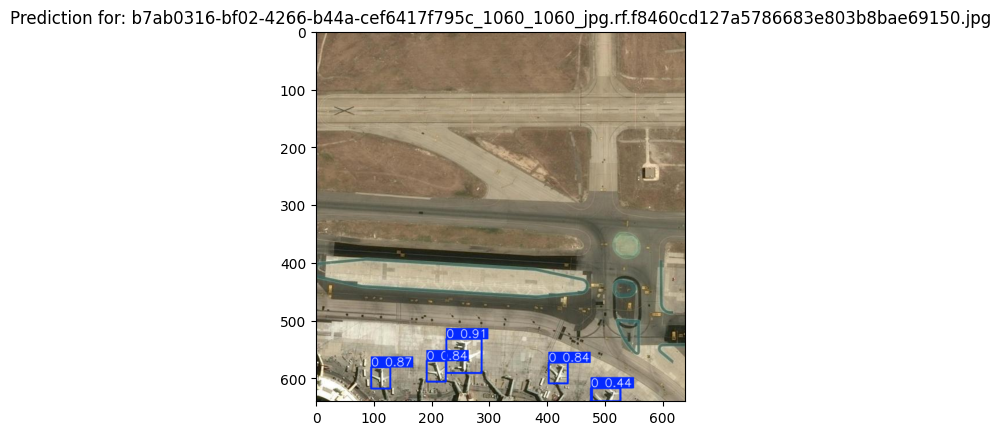


image 1/1 /content/test/images/135fdc4c-6656-4176-9873-9f00c6918293_0_1060_jpg.rf.bcf06d242dea273b787854db7ca7836e.jpg: 640x640 7 0s, 14.2ms
Speed: 3.8ms preprocess, 14.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


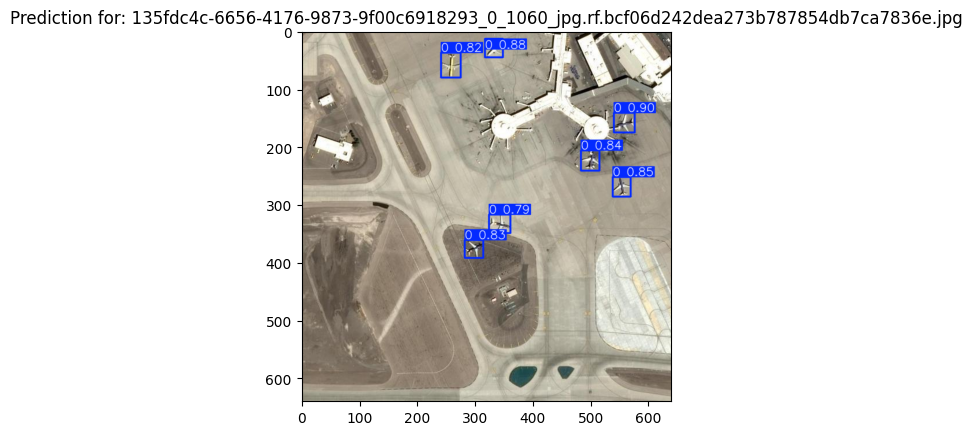


image 1/1 /content/test/images/7635d63c-6b97-4c9c-a7dc-27773d42ed4c_1060_0_jpg.rf.7e8e7a70a5765f64bbff277036aba993.jpg: 640x640 20 0s, 29.2ms
Speed: 7.9ms preprocess, 29.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


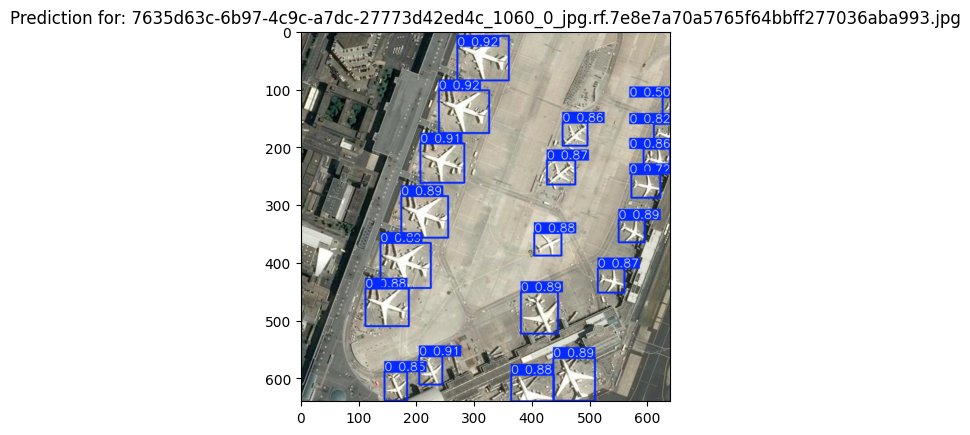


image 1/1 /content/test/images/57af3c0a-b5ae-4e4f-a7f9-6856be2f80e5_0_0_jpg.rf.97141eb39f4c33bbf98e35216f01bc65.jpg: 640x640 16 0s, 17.0ms
Speed: 2.2ms preprocess, 17.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


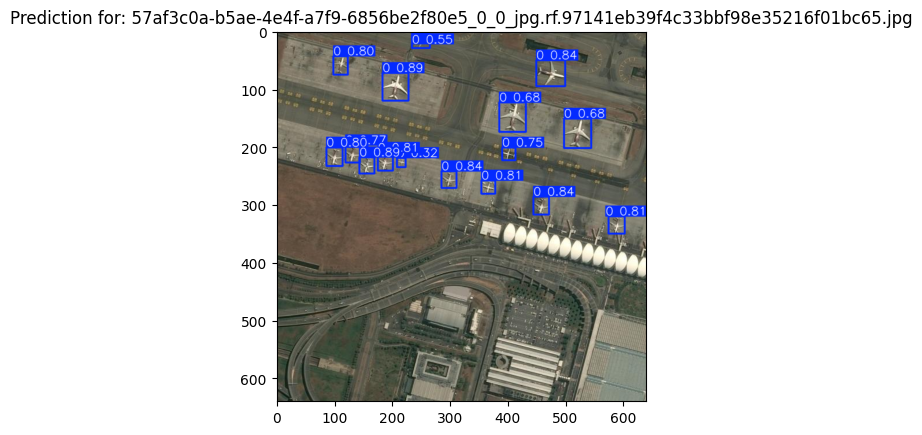


image 1/1 /content/test/images/d8873734-016a-4b9d-9b9e-8bc47eb13fef_0_0_jpg.rf.0b088187d15fbae33d41e85fca58a82c.jpg: 640x640 14 0s, 14.4ms
Speed: 3.0ms preprocess, 14.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


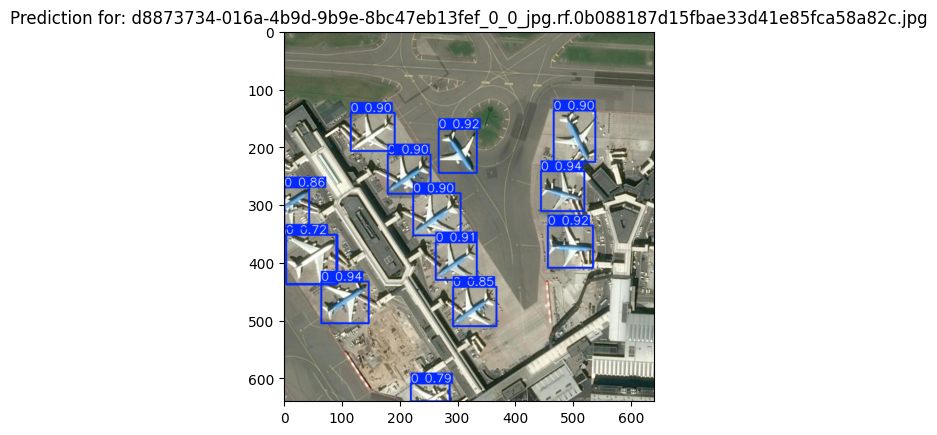


image 1/1 /content/test/images/29324dbf-6043-4521-bd83-44a97ffc5281_0_1060_jpg.rf.079b6670d28e2f1c7db5f15f1c5b3306.jpg: 640x640 16 0s, 14.1ms
Speed: 2.4ms preprocess, 14.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


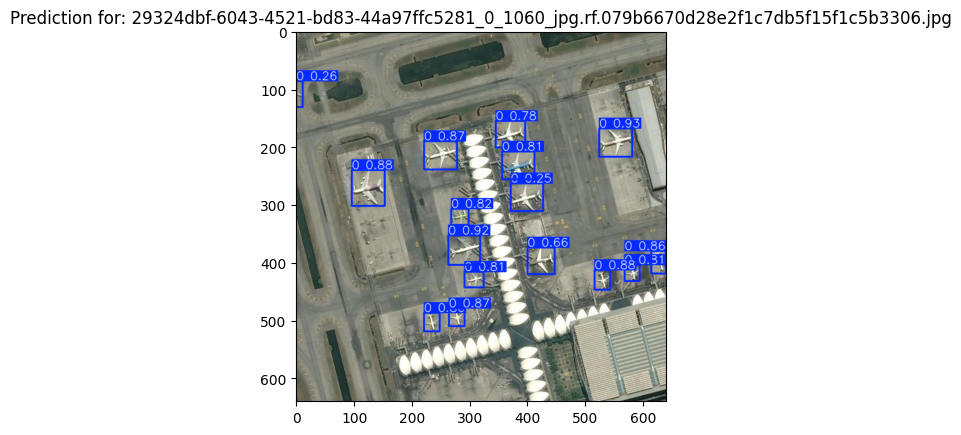


image 1/1 /content/test/images/77f7b57f-5cf2-424d-a952-9847b3c3f35e_1060_0_jpg.rf.1c4621bbae54f3fe8a84ba7932d90db7.jpg: 640x640 14 0s, 14.7ms
Speed: 2.7ms preprocess, 14.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


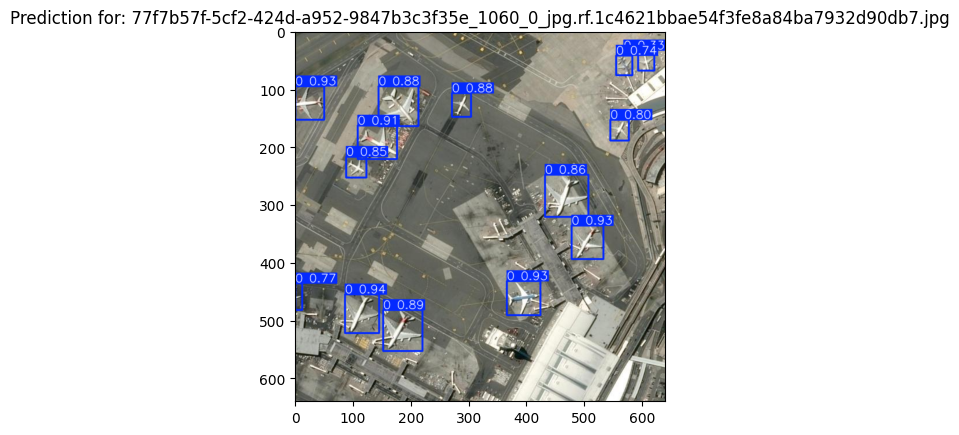


image 1/1 /content/test/images/ef8ff443-e09b-405d-a432-3b5bde0a278b_1060_0_jpg.rf.e45b6e6745e7d3a0f45931654bbe8d66.jpg: 640x640 11 0s, 15.9ms
Speed: 3.8ms preprocess, 15.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


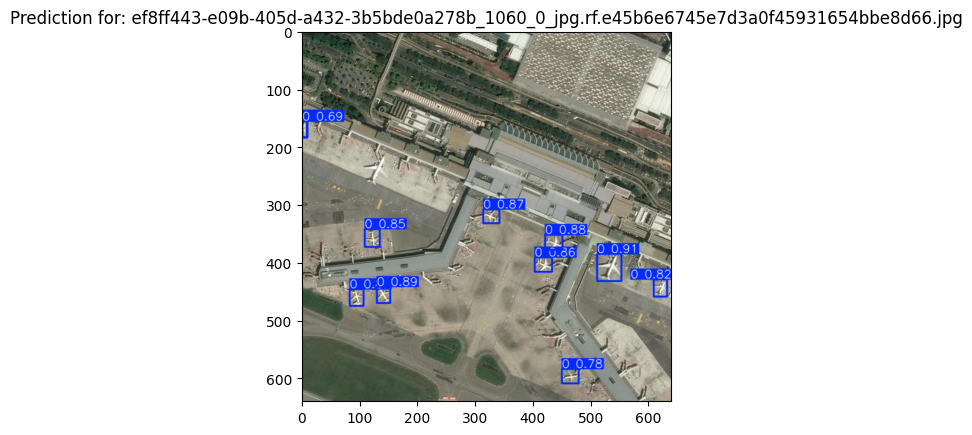


image 1/1 /content/test/images/65e32857-71dc-406b-8583-1ea6467a330f_1060_0_jpg.rf.b08d10f173c4046b46a822aa32774e6f.jpg: 640x640 2 0s, 17.3ms
Speed: 2.2ms preprocess, 17.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


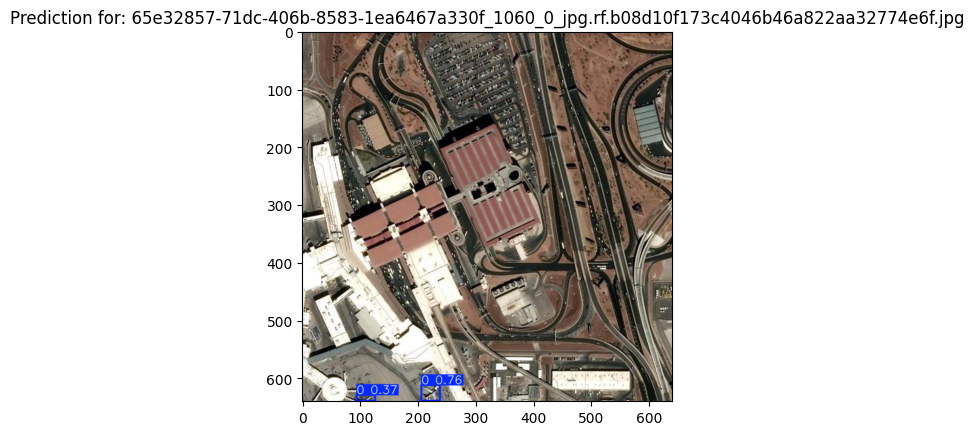


image 1/1 /content/test/images/d8873734-016a-4b9d-9b9e-8bc47eb13fef_0_1060_jpg.rf.9944cafb458131dcff2d07b5267fc7c0.jpg: 640x640 10 0s, 14.5ms
Speed: 2.5ms preprocess, 14.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


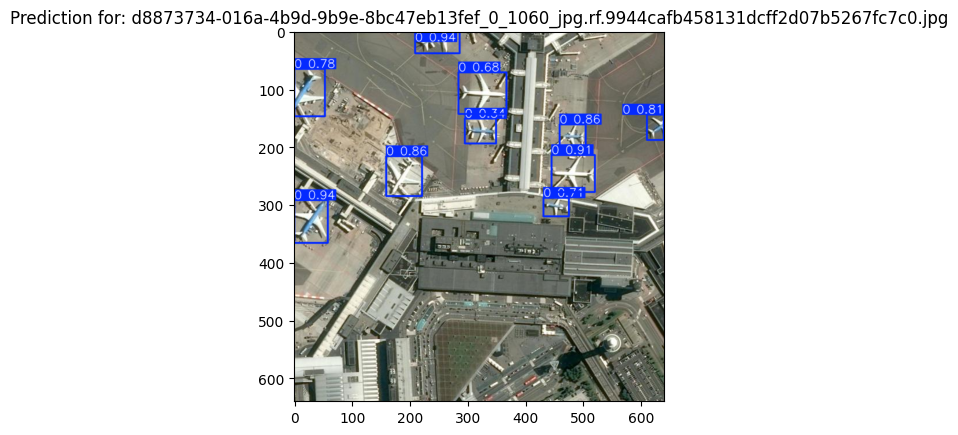

In [ ]:
# prompt: use /content/test/images to test the model prediction

# Define the path to the images you want to test.
test_images_path = '/content/test/images'

# Loop through each image in the directory.
for image_filename in os.listdir(test_images_path)[:10]:
    if image_filename.endswith('.jpg'):  # Check for image files.
        image_path = os.path.join(test_images_path, image_filename)
        try:
            # Perform prediction using the trained model
            results = trained.predict(image_path)

            # Display the image with bounding boxes.
            for result in results:
                im_array = result.plot()  # plot a BGR numpy array of predictions
                plt.imshow(cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB))
                plt.title(f"Prediction for: {image_filename}")
                plt.show()
        except Exception as e:
            print(f"Error processing {image_filename}: {e}")

In [ ]:
!pip install GDAL

In [ ]:
from osgeo import gdal

gdal.VersionInfo()

'3040100'

In [ ]:
img = gdal.Open('/content/Cairo_Airport_2.tif')